In [2]:
import requests, pandas as pd, numpy as np, matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense,Dropout,LSTM
from tensorflow.keras.models import Sequential


In [31]:
api_key='3efb61c1a24f4f888a6bd13ec2b6ce94'
symbol='BTC/USD'
interval='5min'
order='asc'
start_date='2021-10-03 00:00:00'
end_date='2021-10-20 00:00:00'
api_url=f'https://api.twelvedata.com/time_series?apikey={api_key}&interval={interval}&order={order}&symbol={symbol}&start_date={start_date}&end_date={end_date}'
data=requests.get(api_url).json()
data_final=pd.DataFrame(data['values'])
data_final

,datetime,open,high,low,close
0,2021-10-03 00:00:00,47657.69141,47812.28125,47651.53125,47812.28125
1,2021-10-03 00:05:00,47814.57031,47832.17188,47721.78125,47744.39062
2,2021-10-03 00:10:00,47736.80859,47757.73828,47697.87891,47727.98828
3,2021-10-03 00:15:00,47729.85156,47790.03125,47671.51953,47692.07812
4,2021-10-03 00:20:00,47696.42188,47800.28906,47696.42188,47745.17188
...,...,...,...,...,...
4880,2021-10-19 23:40:00,64426.26953,64465.21875,64366.05859,64453.55859
4881,2021-10-19 23:45:00,64470.12891,64487.30859,64330.00000,64416.01172
4882,2021-10-19 23:50:00,64437.71875,64437.71875,64230.64062,64243.85156
4883,2021-10-19 23:55:00,64258.87891,64309.30859,64209.41016,64302.23047


In [7]:
# Save data to a JSON file
import json
with open('data.json', 'w') as file:
    json.dump(data['values'], file)

In [4]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(data_final['close'].values.reshape(-1,1))

In [23]:
scaled_data

array([[0.04137454],
       [0.03746368],
       [0.03651882],
       ...,
       [0.98791977],
       [0.9912827 ],
       [0.98868709]])

In [9]:
time_intervals_to_train=24 # 2hrs*60min/5min =24
prediction_interval=12 #1hr*60min/5min=12 we want to predict in the next hour
#https://www.youtube.com/watch?v=8ortErL1-Og&list=PLxvRLWqiBMjoKc38cGaN3BS-7jbVUmbAt&index=1
x_train=[]
y_train=[]

In [10]:
for i in range(time_intervals_to_train, len(scaled_data)-prediction_interval):
    x_train.append(scaled_data[i-time_intervals_to_train:i,0])
    y_train.append(scaled_data[i+prediction_interval,0])

x_train=np.array(x_train)
y_train=np.array(y_train)

In [15]:
print(x_train.shape)
print(y_train.shape)

(4849, 24)
(4849,)


In [17]:
x_train

array([[0.04137454, 0.03746368, 0.03651882, ..., 0.02836138, 0.02738501,
        0.02630964],
       [0.03746368, 0.03651882, 0.03445021, ..., 0.02738501, 0.02630964,
        0.02870296],
       [0.03651882, 0.03445021, 0.03750869, ..., 0.02630964, 0.02870296,
        0.03068921],
       ...,
       [0.98539369, 0.98138719, 0.97690433, ..., 0.97466695, 0.97357763,
        0.9680356 ],
       [0.98138719, 0.97690433, 0.98049791, ..., 0.97357763, 0.9680356 ,
        0.97223088],
       [0.97690433, 0.98049791, 0.97175159, ..., 0.9680356 , 0.97223088,
        0.98166037]])

In [24]:
x_train=np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_train.shape

(4849, 24, 1)

In [25]:
#https://twelvedata.com/account/api-playground
model=Sequential()
model.add(LSTM(128,return_sequences=True, input_shape=(x_train.shape[1],1),activation='relu'))
model.add(Dropout(0.4))
model.add(LSTM(64,return_sequences=True, activation='relu'))
model.add(Dropout(0.3))
model.add(LSTM(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

d:\Nugenesis\price_prediction_v1\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['accuracy'])

In [27]:
model.fit(x_train,y_train,epochs=10,batch_size=64)

Epoch 1/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 9.0755e-05 - loss: 0.0482
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 2.8979e-04 - loss: 0.0026
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 5.3012e-04 - loss: 0.0018
Epoch 4/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 3.6221e-04 - loss: 0.0016
Epoch 5/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 3.1743e-04 - loss: 0.0017
Epoch 6/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 2.9835e-04 - loss: 0.0016
Epoch 7/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 2.4973e-04 - loss: 0.0015
Epoch 8/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 2.0314e-04 - loss: 0.0014
Epoch 9/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 2.8266e-04 - loss: 0.0017
Epoch 10/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 2.5877e-04 - loss: 0.0014


In [32]:
test_start='2021-10-20 00:00:00'
test_end='2021-10-23 00:00:00'

test_api_url=f'https://api.twelvedata.com/time_series?apikey={api_key}&interval={interval}&order={order}&symbol={symbol}&start_date={test_start}&end_date={test_end}'
test_data=requests.get(test_api_url).json()
test_data_final=pd.DataFrame(test_data['values'])
test_data_final

,datetime,open,high,low,close
0,2021-10-20 00:00:00,64300.01172,64381.44922,64235.94141,64257.17188
1,2021-10-20 00:05:00,64255.21875,64265.83984,64099.76953,64134.44922
2,2021-10-20 00:10:00,64133.71875,64207.78125,64133.71875,64177.23047
3,2021-10-20 00:15:00,64185.44922,64232.28906,64119.21875,64137.94141
4,2021-10-20 00:20:00,64137.69922,64166.08984,64083.42188,64083.42188
...,...,...,...,...,...
850,2021-10-22 23:40:00,60831.53906,60843.91016,60750.00000,60754.03906
851,2021-10-22 23:45:00,60754.98828,60796.92188,60720.00000,60720.50000
852,2021-10-22 23:50:00,60720.01172,60729.32031,60690.42969,60710.87891
853,2021-10-22 23:55:00,60717.87891,60720.78906,60680.14062,60696.71875


In [33]:
# Save data to a JSON file
import json
with open('test.json', 'w') as file:
    json.dump(test_data['values'], file)

In [37]:
#to convert from type object to float
bitcoin_prices=pd.to_numeric(test_data_final['close'],errors='coerce').values
test_inputs=test_data_final['close'].values
test_inputs=test_inputs.reshape(-1,1) #to convert into 2D
model_inputs=scaler.fit_transform(test_inputs)#to squeeze data bbetween 0 and 1

In [53]:
model_inputs.shape

(855, 1)

In [51]:
len(model_inputs)

855

In [41]:
x_test=[]

for x in range(time_intervals_to_train,len(model_inputs)):
    x_test.append(model_inputs[x-time_intervals_to_train:x,0])

x_test=np.array(x_test) #to convert from list to array
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1)) #convert into 3D


In [42]:
x_test.shape

(831, 24, 1)

In [47]:
prediction_prices=model.predict(x_test)
prediction_prices=scaler.inverse_transform(prediction_prices)#numbers are between 0 and 1 so we need inverse transform

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [48]:
prediction_prices

array([[64033.77 ],
       [64022.79 ],
       [64013.656],
       [64002.727],
       [63991.85 ],
       [63981.043],
       [63970.453],
       [63957.133],
       [63943.6  ],
       [63929.586],
       [63915.293],
       [63900.457],
       [63886.86 ],
       [63875.734],
       [63861.85 ],
       [63847.957],
       [63836.754],
       [63825.902],
       [63817.863],
       [63812.2  ],
       [63811.79 ],
       [63813.3  ],
       [63817.3  ],
       [63824.71 ],
       [63830.695],
       [63835.234],
       [63839.996],
       [63844.492],
       [63849.25 ],
       [63852.2  ],
       [63856.027],
       [63860.37 ],
       [63862.953],
       [63866.98 ],
       [63869.98 ],
       [63872.535],
       [63876.156],
       [63879.902],
       [63882.566],
       [63883.297],
       [63883.684],
       [63885.89 ],
       [63888.34 ],
       [63891.785],
       [63891.92 ],
       [63890.062],
       [63885.65 ],
       [63880.582],
       [63875.004],
       [63868.73 ],


<function matplotlib.pyplot.show(close=None, block=None)>

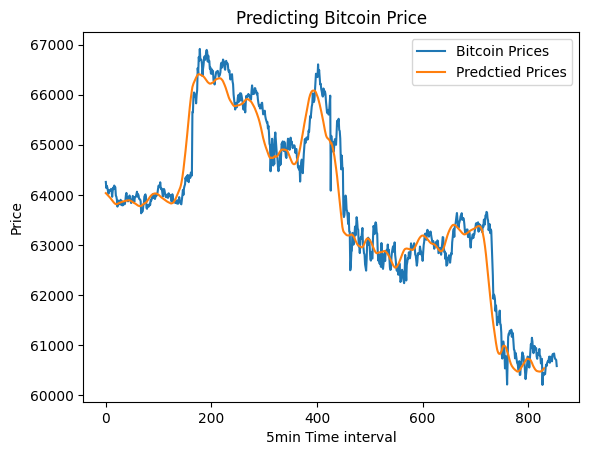

In [50]:
plt.plot(bitcoin_prices,label='Bitcoin Prices')
plt.plot(prediction_prices,label='Predctied Prices')
plt.title('Predicting Bitcoin Price')
plt.xlabel('5min Time interval')
plt.ylabel('Price')
plt.legend()
plt.show

In [83]:
last_data=model_inputs[len(model_inputs)+1-time_intervals_to_train:len(model_inputs)+1,0]
last_data=np.array(last_data)

In [84]:
last_data.shape

(23,)

In [85]:
last_data=np.reshape(last_data,(1,last_data.shape[0],1))

In [87]:
last_data.shape

(1, 23, 1)

In [89]:
prediction=model.predict(last_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step


In [90]:
prediction=scaler.inverse_transform(prediction)

In [91]:
prediction

array([[60609.19]], dtype=float32)